In [1]:
import pandas as pd
import os
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

import networkx as nx

In [2]:
academic_programs_path = r"C:\Projects\connecteddatahub\data\external\university_academics_program_percent.csv"
academic_programs_df = pd.read_csv(academic_programs_path)
academic_programs_df['Year'] = academic_programs_df['year']
print(academic_programs_df.columns)

Index(['carnegie_id', 'AffiliationId', 'year',
       'academics.program_percentage.agriculture',
       'academics.program_percentage.resources',
       'academics.program_percentage.architecture',
       'academics.program_percentage.ethnic_cultural_gender',
       'academics.program_percentage.communication',
       'academics.program_percentage.communications_technology',
       'academics.program_percentage.computer',
       'academics.program_percentage.personal_culinary',
       'academics.program_percentage.education',
       'academics.program_percentage.engineering',
       'academics.program_percentage.engineering_technology',
       'academics.program_percentage.language',
       'academics.program_percentage.family_consumer_science',
       'academics.program_percentage.legal',
       'academics.program_percentage.english',
       'academics.program_percentage.humanities',
       'academics.program_percentage.library',
       'academics.program_percentage.biological',
    

In [3]:
grants_path = r"C:\Projects\connecteddatahub\data\grants\university_grants.csv"
grants_df = pd.read_csv(grants_path)
print(grants_df.columns)


Index(['AffiliationId', 'carnegie_id', 'PrimarySample', 'FullName', 'SystemId',
       'Year', 'student.size', 'fullname_norm', 'matched_name', 'match_score',
       'num_grants', 'total_funding'],
      dtype='object')


In [4]:
# Extract the program percentage columns and identifying columns
program_percentage_columns = [c for c in academic_programs_df.columns if c.startswith("academics.program_percentage.")]
institution_year_columns = ["AffiliationId", "Year"]

# remove any rows where all the program percents are nan
academic_programs_df = academic_programs_df.dropna(subset = program_percentage_columns, how = 'all')

program_data = academic_programs_df[institution_year_columns + program_percentage_columns].copy()

# Ensure everything is numeric and remove any possible values that are not between 0 and 1
program_data[program_percentage_columns] = program_data[program_percentage_columns].apply(pd.to_numeric, errors="coerce").fillna(0.0)
program_data[program_percentage_columns] = program_data[program_percentage_columns].clip(lower=0.0, upper=1.0)

# Normalize the percentages to sum to 1 (for safety, probably already done)
row_total_percentages = program_data[program_percentage_columns].sum(axis=1).replace(0, np.nan)
program_data.loc[row_total_percentages.notna(), program_percentage_columns] = (
    program_data.loc[row_total_percentages.notna(), program_percentage_columns]
    .div(row_total_percentages[row_total_percentages.notna()].values, axis=0)
)
program_data[program_percentage_columns] = program_data[program_percentage_columns].fillna(0.0)

# Merge the grants and academic program proportions data on year and AffiliationId
grants_data = grants_df[institution_year_columns + ["num_grants", "total_funding", "student.size"]].copy()
merged_data = (
    program_data.merge(grants_data, on=institution_year_columns, how="inner")
    .sort_values(institution_year_columns)
    .reset_index(drop=True)
)


# Right now in the grants data, affiliationid is getting assigned to multiple things because its unstandardized, e.g. William and Mary vs College of William and Mary get mapped to the same Id, 
# but have separate rows - need to aggregate them within the grants data not here
aggregation_map = {
    **{c: "mean" for c in program_percentage_columns},
    "num_grants": "sum",
    "total_funding": "sum",
    "student.size": "mean",
}

# for now though, just sum the grants and funding, and average the student size *should be the same
aggregated_data = merged_data.groupby(institution_year_columns, as_index=False).agg(aggregation_map)

# higher entropy - more even distribution
def shannon_entropy(row):
    proportions = row.values
    proportions = proportions[proportions > 0]
    return float(-np.sum(proportions * np.log(proportions))) if proportions.size else 0.0

# higher - more dominated by a few programs
def herfindahl_hhi(row):
    proportions = row.values
    return float(np.sum(np.square(proportions)))


aggregated_data["program_entropy"] = program_data[program_percentage_columns].apply(shannon_entropy, axis=1)
aggregated_data["program_hhi"] = program_data[program_percentage_columns].apply(herfindahl_hhi, axis=1)

# arbitrary groupings to look at together if wanted
stem_programs = {
    "academics.program_percentage.engineering",
    "academics.program_percentage.engineering_technology",
    "academics.program_percentage.computer",
    "academics.program_percentage.mathematics",
    "academics.program_percentage.physical_science",
    "academics.program_percentage.biological",
    "academics.program_percentage.science_technology",
}
humanities_programs = {
    "academics.program_percentage.english",
    "academics.program_percentage.humanities",
    "academics.program_percentage.history",
    "academics.program_percentage.language",
    "academics.program_percentage.visual_performing",
    "academics.program_percentage.philosophy_religious",
    "academics.program_percentage.theology_religious_vocation",
}
health_programs = {"academics.program_percentage.health"}

aggregated_data["stem_program_share"] = aggregated_data[list(stem_programs & set(program_percentage_columns))].sum(axis=1)
aggregated_data["humanities_program_share"] = aggregated_data[list(humanities_programs & set(program_percentage_columns))].sum(axis=1)
aggregated_data["health_program_share"] = aggregated_data[list(health_programs & set(program_percentage_columns))].sum(axis=1)

# add a miniscule count to avoid div by 0, renormalize, convert to log-ratio
epsilon = 1e-6
program_matrix = aggregated_data[program_percentage_columns].values
program_matrix_eps = program_matrix + epsilon
program_matrix_eps = program_matrix_eps / program_matrix_eps.sum(axis=1, keepdims=True)
geometric_mean = np.exp(np.mean(np.log(program_matrix_eps), axis=1, keepdims=True))
clr_transformed = np.log(program_matrix_eps / geometric_mean)
clr_column_names = [c.replace("academics.program_percentage.", "clr_") for c in program_percentage_columns]
clr_dataframe = pd.DataFrame(clr_transformed, columns=clr_column_names, index=aggregated_data.index)

#drop the last col so the vars are linearly independent
dropped_clr_column = clr_column_names[-1]
clr_dataframe = clr_dataframe.drop(columns=[dropped_clr_column])

df_model = pd.concat(
    [
        aggregated_data[
            institution_year_columns
            + [
                "num_grants",
                "total_funding",
                "program_entropy",
                "program_hhi",
                "stem_program_share",
                "humanities_program_share",
                "health_program_share",
                "student.size",
            ]
        ],
        clr_dataframe,
    ],
    axis=1,
)

print(df_model.head())
print(df_model[["num_grants", "total_funding"]].describe())
overdispersion_ratio = df_model["num_grants"].var() / max(1e-9, df_model["num_grants"].mean())
print(f"Overdispersion ratio (var/mean) for num_grants: {overdispersion_ratio:.2f}")


   AffiliationId  Year  num_grants  total_funding  program_entropy  \
0       392282.0  2010           9       617963.0         2.523526   
1       392282.0  2011           4      1095290.0         2.558193   
2       392282.0  2013           9      1179016.0         2.536438   
3       392282.0  2018          17      1971617.0         2.539116   
4       708430.0  2010           3        59517.0         2.456857   

   program_hhi  stem_program_share  humanities_program_share  \
0     0.105039            0.103890                  0.282672   
1     0.096369            0.152430                  0.260652   
2     0.103504            0.184318                  0.214821   
3     0.104587            0.211058                  0.146071   
4     0.123775            0.025997                  0.235776   

   health_program_share  student.size  ...  clr_security_law_enforcement  \
0              0.000000       12899.5  ...                      5.681782   
1              0.000000       12430.0  ...

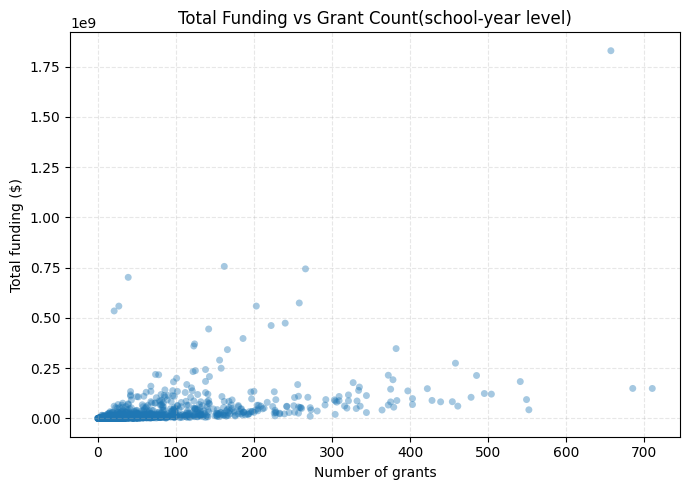

In [5]:
plt.figure(figsize=(7, 5))
plt.scatter(df_model["num_grants"], df_model["total_funding"], 
            alpha=0.4, s=25, edgecolor="none")

plt.ylabel("Total funding ($)")
plt.xlabel("Number of grants")
plt.title("Total Funding vs Grant Count(school-year level)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

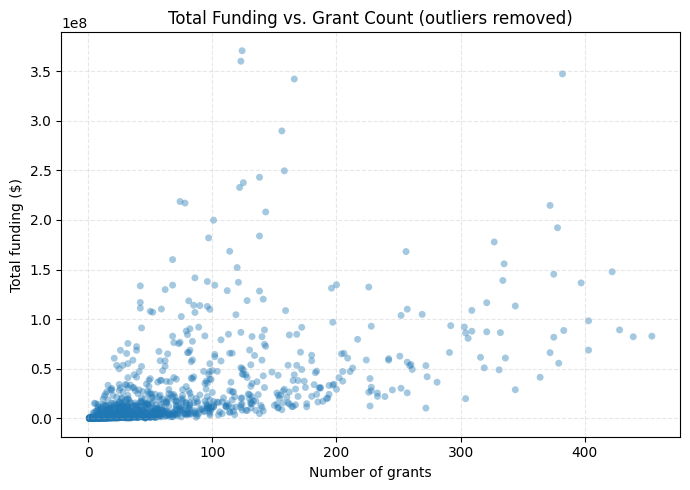

In [6]:
#scaled better without extreme outlier

low_q, high_q = 0.01, 0.99
funding_low, funding_high = df_model["total_funding"].quantile([low_q, high_q])
grants_low, grants_high = df_model["num_grants"].quantile([low_q, high_q])

df_trimmed = df_model[
    (df_model["total_funding"].between(funding_low, funding_high)) &
    (df_model["num_grants"].between(grants_low, grants_high))
]

plt.figure(figsize=(7, 5))
plt.scatter(df_trimmed["num_grants"], df_trimmed["total_funding"],
            alpha=0.4, s=25, edgecolor="none")

plt.ylabel("Total funding ($)")
plt.xlabel("Number of grants")
plt.title("Total Funding vs. Grant Count (outliers removed)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
print(df_model.columns)

Index(['AffiliationId', 'Year', 'num_grants', 'total_funding',
       'program_entropy', 'program_hhi', 'stem_program_share',
       'humanities_program_share', 'health_program_share', 'student.size',
       'clr_agriculture', 'clr_resources', 'clr_architecture',
       'clr_ethnic_cultural_gender', 'clr_communication',
       'clr_communications_technology', 'clr_computer',
       'clr_personal_culinary', 'clr_education', 'clr_engineering',
       'clr_engineering_technology', 'clr_language',
       'clr_family_consumer_science', 'clr_legal', 'clr_english',
       'clr_humanities', 'clr_library', 'clr_biological', 'clr_mathematics',
       'clr_military', 'clr_multidiscipline', 'clr_parks_recreation_fitness',
       'clr_philosophy_religious', 'clr_theology_religious_vocation',
       'clr_physical_science', 'clr_science_technology', 'clr_psychology',
       'clr_security_law_enforcement',
       'clr_public_administration_social_service', 'clr_social_science',
       'clr_constructio

In [8]:
subset_cols = ["num_grants", "student.size"] + [c for c in df_model.columns if c.startswith("clr_")]
df_valid = df_model[subset_cols].dropna(subset=subset_cols)

# Residualize both num_grants and funding cols wrt student_size
X = df_valid[["student.size"]].values
y = df_valid["num_grants"].values

# residuals of num_grants after controlling for student_size
reg_y = LinearRegression().fit(X, y)
y_resid = y - reg_y.predict(X)

corrs = {}

for col in [c for c in df_valid.columns if c.startswith("clr_")]:
    # residuals of clr_ variable after controlling for student_size
    reg_x = LinearRegression().fit(X, df_valid[col].values)
    x_resid = df_valid[col].values - reg_x.predict(X)
    
    # Spearman correlation between residuals
    rho, _ = spearmanr(x_resid, y_resid)
    corrs[col] = rho

corrs = pd.Series(corrs).sort_values(ascending=False)

print(f"Positive Associations (controlling for size):\n{corrs.head(15)}\n")
print(f"Negative Associations (controlling for size):\n{corrs.tail(15)}\n")
print(f"Rows retained after dropping NaNs: {len(df_valid):,}")

Positive Associations (controlling for size):
clr_ethnic_cultural_gender         0.312152
clr_philosophy_religious           0.257578
clr_social_science                 0.234797
clr_mathematics                    0.233853
clr_biological                     0.220916
clr_resources                      0.218266
clr_physical_science               0.210742
clr_engineering                    0.206369
clr_computer                       0.170097
clr_language                       0.162710
clr_architecture                   0.145156
clr_multidiscipline                0.113047
clr_visual_performing              0.062123
clr_english                        0.060504
clr_theology_religious_vocation    0.052081
dtype: float64

Negative Associations (controlling for size):
clr_library                                 0.007296
clr_mechanic_repair_technology             -0.006375
clr_communications_technology              -0.019947
clr_agriculture                            -0.032702
clr_transportation  

In [9]:
subset_cols = ["total_funding", "student.size"] + [c for c in df_model.columns if c.startswith("clr_")]
df_valid = df_model[subset_cols].dropna(subset=subset_cols)

# Residualize both num_grants and funding columns w.r.t student_size
X = df_valid[["student.size"]].values
y = df_valid["total_funding"].values

# residuals of num_grants after controlling for student_size
reg_y = LinearRegression().fit(X, y)
y_resid = y - reg_y.predict(X)

corrs = {}

for col in [c for c in df_valid.columns if c.startswith("clr_")]:
    # residuals of funding variable
    reg_x = LinearRegression().fit(X, df_valid[col].values)
    x_resid = df_valid[col].values - reg_x.predict(X)
    
    # Spearman correlation between residuals
    rho, _ = spearmanr(x_resid, y_resid)
    corrs[col] = rho

corrs = pd.Series(corrs).sort_values(ascending=False)

print(f"Positive Associations (controlling for size):\n{corrs.head(10)}\n")
print(f"Negative Associations (controlling for size):\n{corrs.tail(10)}\n")
print(f"Rows retained after dropping NaNs: {len(df_valid):,}")

Positive Associations (controlling for size):
clr_engineering             0.233630
clr_social_science          0.219372
clr_biological              0.215522
clr_mathematics             0.207555
clr_physical_science        0.204846
clr_architecture            0.202239
clr_agriculture             0.195158
clr_philosophy_religious    0.184983
clr_resources               0.177282
clr_language                0.165806
dtype: float64

Negative Associations (controlling for size):
clr_health                                 -0.027967
clr_family_consumer_science                -0.030866
clr_business_marketing                     -0.031927
clr_public_administration_social_service   -0.038825
clr_communication                          -0.042781
clr_education                              -0.088291
clr_humanities                             -0.092121
clr_engineering_technology                 -0.099200
clr_parks_recreation_fitness               -0.136420
clr_security_law_enforcement               -0

In [10]:
corrs = df_model.filter(like="clr_").corrwith(df_model["num_grants"], method="spearman").sort_values(ascending=False)
print(f"Positive Associations: \n{corrs.head(10)} \n")   # top positive associations
print(f"Negative Associations: \n{corrs.tail(10)}")   # top negative associations

Positive Associations: 
clr_ethnic_cultural_gender    0.354407
clr_philosophy_religious      0.281424
clr_social_science            0.229670
clr_engineering               0.227317
clr_resources                 0.224685
clr_language                  0.211576
clr_mathematics               0.195249
clr_biological                0.187010
clr_architecture              0.163700
clr_physical_science          0.158393
dtype: float64 

Negative Associations: 
clr_library                      -0.105771
clr_communications_technology    -0.107375
clr_mechanic_repair_technology   -0.117996
clr_transportation               -0.137376
clr_business_marketing           -0.171713
clr_education                    -0.175624
clr_parks_recreation_fitness     -0.184864
clr_health                       -0.226955
clr_engineering_technology       -0.238367
clr_security_law_enforcement     -0.295685
dtype: float64


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


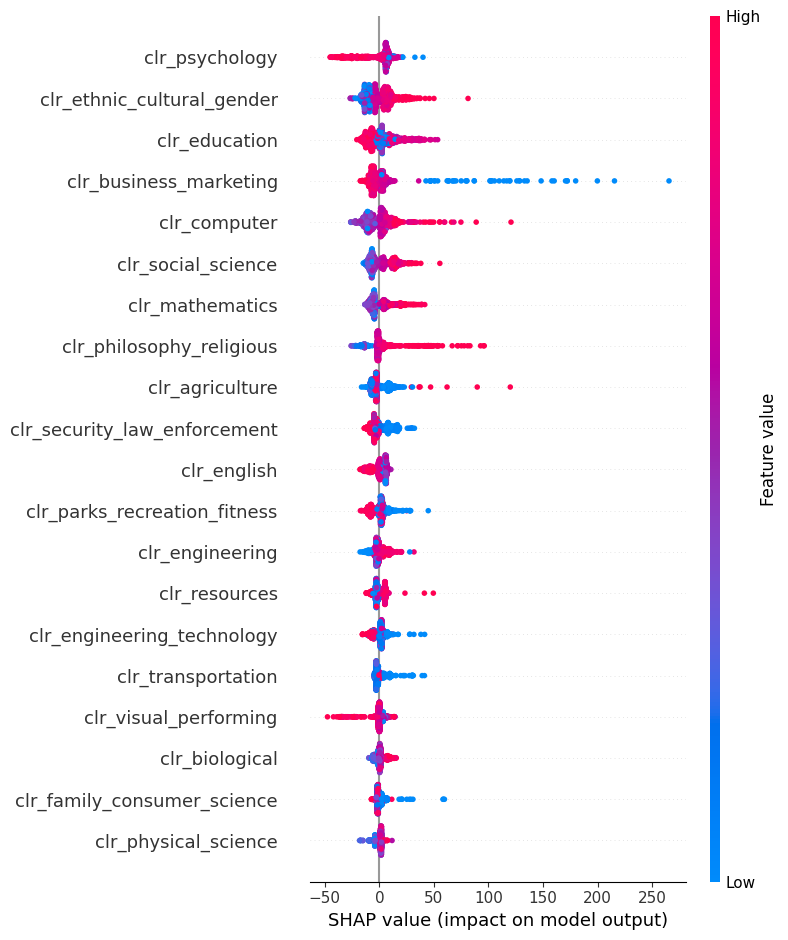

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
X = df_model.filter(like="clr_")
y = df_model["num_grants"]
gb = GradientBoostingRegressor().fit(X, y)
import shap
shap_values = shap.Explainer(gb, X).shap_values(X)
shap.summary_plot(shap_values, X)


In [12]:
edge_path = r"C:\Projects\connecteddatahub\data\interlocks\interlock_edges.csv"
edge_df = pd.read_csv(edge_path)


node_path = r"C:\Projects\connecteddatahub\data\interlocks\interlock_nodes.csv"
node_df = pd.read_csv(node_path)

print(f"Edge df cols: {edge_df.columns}\n")
print(f"Node df cols: {node_df.columns}")

Edge df cols: Index(['Year', 'AffiliationId_1', 'Institution_1', 'AffiliationId_2',
       'Institution_2', 'InterlockCount', 'BoardSize_1', 'BoardSize_2',
       'WeightNorm', 'Weakness', 'Source', 'Target', 'Weight',
       'EdgeEntropyBits'],
      dtype='object')

Node df cols: Index(['Year', 'Id', 'Label', 'SystemId', 'degree', 'degree_centrality',
       'eigenvector_centrality', 'betweenness_centrality', 'clustering',
       'modularity_class', 'interlock_entropy_bits', 'strength', 'Institution',
       'AffiliationId'],
      dtype='object')


In [13]:
node_df["AffiliationId"] = node_df["Id"].astype(str)
grants_df["AffiliationId"] = grants_df["AffiliationId"].astype(str)

node_cols = [
    "Year","AffiliationId","SystemId","Label","degree","degree_centrality",
    "eigenvector_centrality","betweenness_centrality","clustering",
    "modularity_class","interlock_entropy_bits","strength"
]
grant_cols = ["AffiliationId","Year","student.size","num_grants","total_funding"]

N = node_df[node_cols].copy()
G = grants_df[grant_cols].dropna(subset=["student.size"]).copy()

Z = N.merge(G, on=["AffiliationId","Year"], how="left")
print(f"Full merged frame: {len(Z):,} rows, {Z['Year'].nunique()} distinct years")

Full merged frame: 1,254 rows, 11 distinct years


In [14]:
def residualize_by_year(df):
    out = []
    for yr, g in df.groupby("Year"):
        g = g.dropna(subset=["student.size","num_grants","total_funding"]).copy()
        if len(g) < 10:
            continue
        g["log_students"] = np.log1p(g["student.size"])
        g["log_grants"]   = np.log1p(g["num_grants"])
        g["log_funding"]  = np.log1p(g["total_funding"])

        # regress log_grants ~ log_students
        lr_g = LinearRegression().fit(g[["log_students"]], g["log_grants"])
        g["grants_resid"] = g["log_grants"] - lr_g.predict(g[["log_students"]])

        # regress log_funding ~ log_students
        lr_f = LinearRegression().fit(g[["log_students"]], g["log_funding"])
        g["funding_resid"] = g["log_funding"] - lr_f.predict(g[["log_students"]])

        out.append(g)
    return pd.concat(out, ignore_index=True)

Z_resid = residualize_by_year(Z)
print(Z_resid[["Year","grants_resid","funding_resid"]].groupby("Year").describe().round(2).head())


     grants_resid                                          funding_resid       \
            count mean   std   min   25%   50%   75%   max         count mean   
Year                                                                            
2010        121.0 -0.0  1.57 -4.13 -1.41 -0.04  1.27  2.71         121.0  0.0   
2011        107.0  0.0  1.71 -3.42 -1.08  0.31  1.38  2.36         107.0  0.0   
2013         99.0 -0.0  1.67 -3.12 -1.02  0.42  1.26  2.67          99.0 -0.0   
2018        107.0 -0.0  1.85 -4.50 -1.51  0.31  1.60  3.21         107.0 -0.0   

                                           
       std    min   25%   50%   75%   max  
Year                                       
2010  4.53 -15.70 -0.89  0.82  3.01  6.32  
2011  4.87 -12.10 -1.29  1.07  3.48  5.76  
2013  4.68 -11.86 -1.37  0.67  3.09  6.06  
2018  4.81 -12.15 -1.94  1.02  3.20  6.15  


In [15]:
metrics = [
    "degree","degree_centrality","eigenvector_centrality",
    "betweenness_centrality","clustering","strength","interlock_entropy_bits"
]

corrs = []
for yr, g in Z_resid.groupby("Year"):
    if len(g) < 20:
        continue
    sub = g[["grants_resid","funding_resid"] + metrics].corr()
    for target in ["grants_resid","funding_resid"]:
        for m in metrics:
            corrs.append({"Year": yr, "target": target, "metric": m, "r": sub.loc[target,m]})
corrs_df = pd.DataFrame(corrs)
pivot = corrs_df.pivot_table(index="Year", columns="metric", values="r")
print(pivot.round(3))


metric  betweenness_centrality  clustering  degree  degree_centrality  \
Year                                                                    
2010                    -0.054       0.050  -0.231             -0.231   
2011                    -0.311       0.186  -0.233             -0.233   
2013                     0.130      -0.037  -0.190             -0.190   
2018                     0.156       0.224   0.260              0.260   

metric  eigenvector_centrality  interlock_entropy_bits  strength  
Year                                                              
2010                    -0.150                  -0.118    -0.112  
2011                    -0.073                  -0.103    -0.024  
2013                     0.224                  -0.096     0.026  
2018                    -0.336                   0.265     0.225  


In [16]:
from collections import defaultdict

# ensure correct dtypes
for c in ["AffiliationId_1", "AffiliationId_2"]:
    if c in edge_df.columns:
        edge_df[c] = edge_df[c].astype(str)
node_df["AffiliationId"] = node_df["Id"].astype(str)

bridge_list = []

# iterate through years
for yr, Eyr in edge_df.groupby("Year"):
    Nyr = node_df.query("Year == @yr")[["AffiliationId","modularity_class"]].drop_duplicates()
    comm_of = Nyr.set_index("AffiliationId")["modularity_class"].to_dict()

    total_weight = defaultdict(float)
    bridge_weight = defaultdict(float)

    for _, row in Eyr.iterrows():
        u, v, w = row["AffiliationId_1"], row["AffiliationId_2"], row.get("Weakness", np.nan)
        if pd.isna(u) or pd.isna(v) or u == v:
            continue
        if pd.isna(w):
            continue

        cu, cv = comm_of.get(u), comm_of.get(v)

        # accumulate total Weakness (higher = weaker tie)
        total_weight[u] += w
        total_weight[v] += w

        # if endpoints are in different communities, count it as bridging
        if cu is not None and cv is not None and cu != cv:
            bridge_weight[u] += w
            bridge_weight[v] += w

    # summarize this year’s node-level results
    tmp = pd.DataFrame({
        "AffiliationId": list(total_weight.keys()),
        "Year": yr,
        "bridge_share": [
            bridge_weight[n] / total_weight[n] if total_weight[n] > 0 else np.nan
            for n in total_weight.keys()
        ],
        "total_weakness": [total_weight[n] for n in total_weight.keys()],
        "bridge_weakness": [bridge_weight[n] for n in total_weight.keys()],
    })
    bridge_list.append(tmp)

bridge_df = pd.concat(bridge_list, ignore_index=True)
print(f"bridge_df: {len(bridge_df):,} rows across {bridge_df['Year'].nunique()} years")
print(bridge_df.head())


bridge_df: 1,082 rows across 11 years
  AffiliationId  Year  bridge_share  total_weakness  bridge_weakness
0          1003  1999           0.0        0.170614              0.0
1     200719446  1999           0.0        1.304386              0.0
2    2799495847  1999           0.0        0.170614              0.0
3        392282  1999           0.0        0.468421              0.0
4      71965598  1999           0.0        0.468421              0.0


In [17]:
Z_bridge = Z_resid.merge(bridge_df, on=["AffiliationId","Year"], how="left")

print(Z_bridge[["Year","bridge_share","grants_resid","funding_resid"]].describe().T.round(3))


               count      mean    std       min       25%       50%       75%  \
Year           434.0  2012.903  3.110  2010.000  2010.000  2011.000  2013.000   
bridge_share   434.0     0.125  0.217     0.000     0.000     0.000     0.263   
grants_resid   434.0    -0.000  1.693    -4.501    -1.392     0.262     1.372   
funding_resid  434.0    -0.000  4.702   -15.703    -1.311     0.861     3.160   

                    max  
Year           2018.000  
bridge_share      0.745  
grants_resid      3.211  
funding_resid     6.321  


In [18]:
results = []
for yr, g in Z_bridge.groupby("Year"):
    if g["bridge_share"].notna().sum() < 20:
        continue
    corr = g[["bridge_share","grants_resid","funding_resid"]].corr().round(3)
    results.append({
        "Year": yr,
        "r_bridge_grants": corr.loc["bridge_share","grants_resid"],
        "r_bridge_funding": corr.loc["bridge_share","funding_resid"],
        "n": len(g)
    })

bridge_years = pd.DataFrame(results).set_index("Year").sort_index()
print(bridge_years)


      r_bridge_grants  r_bridge_funding    n
Year                                        
2010           -0.128            -0.257  121
2011           -0.066            -0.126  107
2013            0.076             0.164   99
2018            0.247             0.167  107


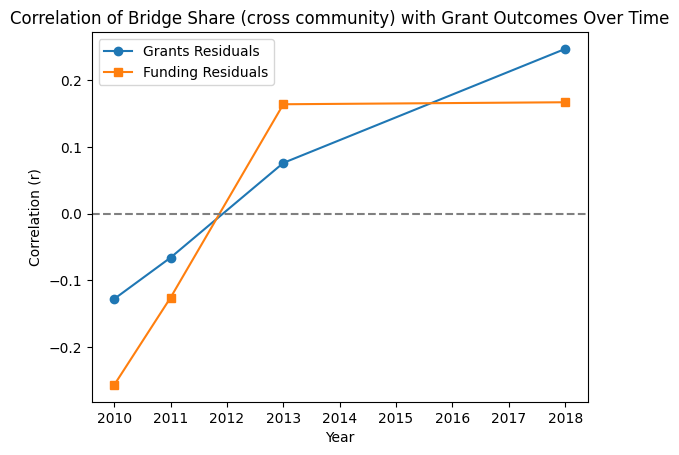

In [19]:

bridge_years.sort_index(inplace=True)
plt.plot(bridge_years.index, bridge_years["r_bridge_grants"], marker="o", label="Grants Residuals")
plt.plot(bridge_years.index, bridge_years["r_bridge_funding"], marker="s", label="Funding Residuals")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Correlation of Bridge Share (cross community) with Grant Outcomes Over Time")
plt.xlabel("Year")
plt.ylabel("Correlation (r)")
plt.legend()
plt.show()


[2013] nodes=90, edges=109
Detected 13 communities


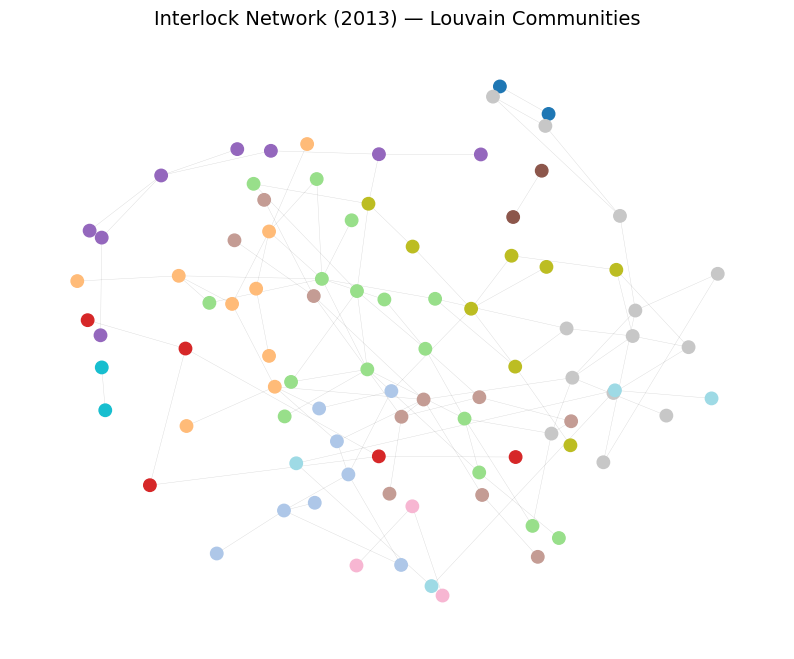

In [20]:
from networkx.algorithms.community import louvain_communities
import random

# ---------------------
# PARAMETERS
# ---------------------
YEAR = 2013  # change to any year
weight_col = "Weakness"  # you can use Weakness or InterlockCount, etc.

# ---------------------
# 1. Filter for this year and clean
# ---------------------
E = edge_df.query("Year == @YEAR").copy()
E = E.dropna(subset=["AffiliationId_1", "AffiliationId_2", weight_col])
E = E[E["AffiliationId_1"] != E["AffiliationId_2"]]

# ensure IDs are strings
E["AffiliationId_1"] = E["AffiliationId_1"].astype(str)
E["AffiliationId_2"] = E["AffiliationId_2"].astype(str)

# ---------------------
# 2. Build the graph (weighted, undirected)
# ---------------------
G = nx.Graph()
for _, row in E.iterrows():
    u, v, w = row["AffiliationId_1"], row["AffiliationId_2"], row[weight_col]
    if pd.notna(w):
        G.add_edge(u, v, weight=w)

print(f"[{YEAR}] nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")

# ---------------------
# 3. Run Louvain community detection
# ---------------------
communities = louvain_communities(G, weight="weight", seed=42, resolution=1.0)
print(f"Detected {len(communities)} communities")

# Create a mapping {node: community_id}
comm_map = {}
for i, com in enumerate(communities):
    for n in com:
        comm_map[n] = i

# ---------------------
# 4. Layout (positions) — spring layout is fine for small networks
# ---------------------
pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)

# Assign a color per community
unique_comms = list(set(comm_map.values()))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_comms)))

node_colors = [colors[comm_map[n] % len(colors)] for n in G.nodes()]

# ---------------------
# 5. Draw the graph
# ---------------------
plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.3)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=80)
plt.title(f"Interlock Network ({YEAR}) — Louvain Communities", fontsize=14)
plt.axis("off")
plt.show()

In [21]:
exposure_list = []

for yr, Eyr in edge_df.groupby("Year"):
    # only keep valid edges
    Eyr = Eyr.dropna(subset=["AffiliationId_1","AffiliationId_2","Weakness"])
    Eyr = Eyr[Eyr["AffiliationId_1"] != Eyr["AffiliationId_2"]]

    # accumulate per node
    node_weak = defaultdict(list)
    for _, row in Eyr.iterrows():
        u, v, w = row["AffiliationId_1"], row["AffiliationId_2"], row["Weakness"]
        node_weak[u].append(w)
        node_weak[v].append(w)

    # compute node-level summaries
    rows = []
    for node, w_list in node_weak.items():
        w_arr = np.array(w_list)
        total_w = w_arr.sum()
        avg_w = w_arr.mean()
        # normalize for entropy
        p = w_arr / w_arr.sum() if w_arr.sum() > 0 else np.full_like(w_arr, 1/len(w_arr))
        entropy = -(p * np.log(p + 1e-12)).sum()  # bits-like heterogeneity
        rows.append({
            "AffiliationId": node,
            "Year": yr,
            "total_weakness": total_w,
            "avg_weakness": avg_w,
            "weakness_entropy": entropy,
            "degree_edges": len(w_arr)
        })

    exposure_list.append(pd.DataFrame(rows))

weak_exposure_df = pd.concat(exposure_list, ignore_index=True)
print(f"Weak exposure table: {len(weak_exposure_df):,} rows, {weak_exposure_df['Year'].nunique()} years")
print(weak_exposure_df.head())

Weak exposure table: 1,082 rows, 11 years
  AffiliationId  Year  total_weakness  avg_weakness  weakness_entropy  \
0          1003  1999        0.170614      0.085307      5.115970e-01   
1     200719446  1999        1.304386      0.326096      1.203210e+00   
2    2799495847  1999        0.170614      0.085307      5.115970e-01   
3        392282  1999        0.468421      0.468421     -1.000089e-12   
4      71965598  1999        0.468421      0.468421     -1.000089e-12   

   degree_edges  
0             2  
1             4  
2             2  
3             1  
4             1  


In [22]:
Z_exposure = Z_resid.merge(weak_exposure_df, on=["AffiliationId","Year"], how="left")
print(Z_exposure[["Year","avg_weakness","weakness_entropy","grants_resid","funding_resid"]].describe().round(3))


           Year  avg_weakness  weakness_entropy  grants_resid  funding_resid
count   434.000       434.000           434.000       434.000        434.000
mean   2012.903         0.532             0.633        -0.000         -0.000
std       3.110         0.155             0.579         1.693          4.702
min    2010.000         0.052            -0.000        -4.501        -15.703
25%    2010.000         0.465            -0.000        -1.392         -1.311
50%    2011.000         0.530             0.692         0.262          0.861
75%    2013.000         0.633             1.096         1.372          3.160
max    2018.000         0.787             2.036         3.211          6.321


In [23]:
results = []
for yr, g in Z_exposure.groupby("Year"):
    if g["avg_weakness"].notna().sum() < 20:
        continue
    corr = g[["avg_weakness","weakness_entropy","grants_resid","funding_resid"]].corr().round(3)
    results.append({
        "Year": yr,
        "r_avgweak_grants": corr.loc["avg_weakness","grants_resid"],
        "r_avgweak_funding": corr.loc["avg_weakness","funding_resid"],
        "r_entropy_grants": corr.loc["weakness_entropy","grants_resid"],
        "r_entropy_funding": corr.loc["weakness_entropy","funding_resid"],
        "n": len(g)
    })

weak_years = pd.DataFrame(results).set_index("Year").sort_index()
print(weak_years)


      r_avgweak_grants  r_avgweak_funding  r_entropy_grants  \
Year                                                          
2010             0.088              0.060             0.017   
2011            -0.158             -0.216            -0.056   
2013             0.029              0.083             0.015   
2018            -0.048              0.023             0.271   

      r_entropy_funding    n  
Year                          
2010             -0.168  121  
2011             -0.067  107  
2013             -0.029   99  
2018              0.207  107  


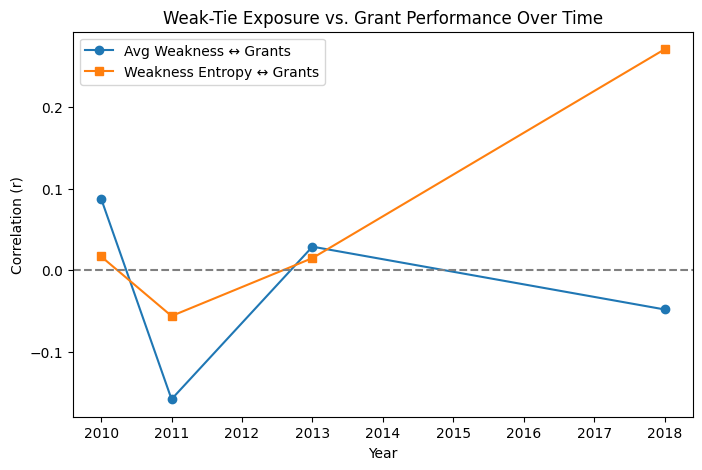

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(weak_years.index, weak_years["r_avgweak_grants"], marker="o", label="Avg Weakness ↔ Grants")
plt.plot(weak_years.index, weak_years["r_entropy_grants"], marker="s", label="Weakness Entropy ↔ Grants")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Correlation (r)")
plt.title("Weak-Tie Exposure vs. Grant Performance Over Time")
plt.legend()
plt.show()
